<a href="https://colab.research.google.com/github/Mboubaker/Lidar_Evidential_occupancy_grid_mapping-/blob/main/Sensor_Fusion_Integrating_LiDAR_and_Camera_Sensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sensor Fusion: Integrating LiDAR and Camera Sensors**

Sensor fusion between LiDAR and camera is a common technique used in autonomous vehicle perception and other computer vision applications. The idea is to leverage the strengths of each sensor to compensate for the weaknesses of the other, resulting in more accurate and robust environment perception.

Here's how the fusion of LiDAR and camera sensors can contribute to creating a more precise semantic occupancy map:

  1. Data Complementarity: Data provided by LiDAR and camera sensors are complementary. LiDAR provides precise information about distance and environment geometry, while the camera provides rich information about color, texture, and semantic features of the scene.

  2. Object Detection: Combining LiDAR and camera data enables more robust object detection in the environment. For example, objects can be detected using object detection algorithms based on camera data, and then their precise position and shape can be determined using LiDAR data.

  3. Semantic Segmentation: Fusion of LiDAR and camera data allows more accurate semantic segmentation of the scene. Camera data can be used to label pixels with semantic classes such as road, sidewalk, car, tree, etc. LiDAR data can then be used to refine this segmentation by considering the scene's geometry and eliminating classification errors based solely on color or texture.

  4. Occupancy Mapping: Fusion of LiDAR and camera data enables the creation of more accurate occupancy maps. By combining the geometry information provided by LiDAR with the semantic information provided by the camera, it's possible to create occupancy maps that not only indicate which pixels in the image are occupied by objects but also what type of object occupies each pixel.

  5. Robustness and Redundancy: Using two different sensors, data fusion also increases system robustness. If one sensor fails or provides incorrect data under certain conditions (e.g., darkness or weather conditions), the other sensor can compensate and provide correct information.
  
The fusion of LiDAR and camera sensors combines the advantages of each sensor to achieve more precise and robust environment perception, which is essential for many autonomous vehicle and robotics applications.




**Importing Libraries for Image Processing and Data Analysis**

In [76]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from scipy import stats
from time import sleep
import tensorflow as tf
from IPython.display import clear_output
import zipfile
from PIL import Image
import math
import csv


In [52]:
folder_path = '/content/drive/MyDrive/Data/Vehicle_1 vehicle.tesla.model3'

In [53]:
camera_intrinsic=np.load(os.path.join(folder_path, "pos_matrices/K.npy"))

This **load_data** function loads necessary data from a specified folder for a given date. It loads a raw image (RGB), a semantic image, and LiDAR data from corresponding files in subfolders of the main folder. It also filters LiDAR points that are at least 1.5 meters away from the camera. Finally, it returns these data for further analysis or processing.

In [84]:
def load_data(folder_path, date):
    ### Construct the filename using the provided timestamp

    i = str(date)

    folder_path2= os.path.join(folder_path, "rgb/")
    img_file_path =  os.path.join(folder_path2, str(i) + '.jpg')

    ### Load the image data
    img_raw = Image.open(img_file_path)

    img_raw = np.array(img_raw)
    ### Load the semantic data (only x,y,z data)
    folder_path3= os.path.join(folder_path, "semantic/")
    img_file_path =  os.path.join(folder_path3, str(i) + '.jpg')

    ### Load the image data
    img_seg = Image.open(img_file_path)

    img_seg = np.array(img_seg)
    ### Only use LiDAR points that are at least 2.5 m away

    folder_path1= os.path.join(folder_path, "Lidar/")
    lidar_file_path =  os.path.join(folder_path1, str(i) + '.npy')





    lidar_raw = np.load(lidar_file_path)
    lidar_raw=np.load(lidar_file_path).reshape(-1, 4)
    intensity = np.array(lidar_raw[:, 3])
    lidar_raw = lidar_raw[:, :3]

    lidar_raw = lidar_raw[lidar_raw[:, 2] <= 0, :]
    dist = np.linalg.norm(lidar_raw, axis=1)
    lidar_raw = lidar_raw[dist >= 1.5]

    return img_seg, lidar_raw,  intensity

This **transform_coordinate** function converts LiDAR points from LiDAR coordinate space to camera coordinate space. It takes LiDAR points and a date as input parameters. Internally, it loads transformation matrices from LiDAR to world space and from world space to camera space. Then, it applies these transformations to the LiDAR points, first converting them to world space and then to camera space. Finally, it returns the transformed points in camera coordinate space.

In [85]:
### Transform the LiDAR points into camera coordinate
def transform_coordinate(lidar_points,date):

    i = str(date)
    folder_path12= os.path.join(folder_path, "pos_matrices/lidar_2_world/")
    l2w_matrix_file_path =  os.path.join(folder_path12, str(i) + '.npy')


    l2w_matrix = np.load(l2w_matrix_file_path)


    folder_path18= os.path.join(folder_path, "pos_matrices/world_2_camera/")
    w2c_matrix_file_path =  os.path.join(folder_path18, str(i) + '.npy')


    w2c_matrix = np.load(w2c_matrix_file_path)
    inp = lidar_points.copy()
    ones_column = np.ones((inp.shape[0], 1))
    inp=np.concatenate((inp, ones_column), axis=1)



  # Transform the points from lidar space to world space.
    world_points = np.dot(l2w_matrix, inp.T)

    inp = np.dot(w2c_matrix, world_points).T

    return inp[:,:3]

This code segment loads data for the timestamp 30 using the load_data function and transforms the LiDAR points to camera coordinate space using the transform_coordinate function. After that, it visualizes the semantic image and the LiDAR point cloud side by side.

The subplot on the left displays the semantic image (img_seg) with a title indicating its semantic nature. The subplot on the right shows the LiDAR point cloud (lidar_raw) plotted on the x-y plane, with a red cross marking the origin. The visualization is presented in a figure with two subplots arranged horizontally.
Finally, the plt.show() function displays the figure containing both subplots.

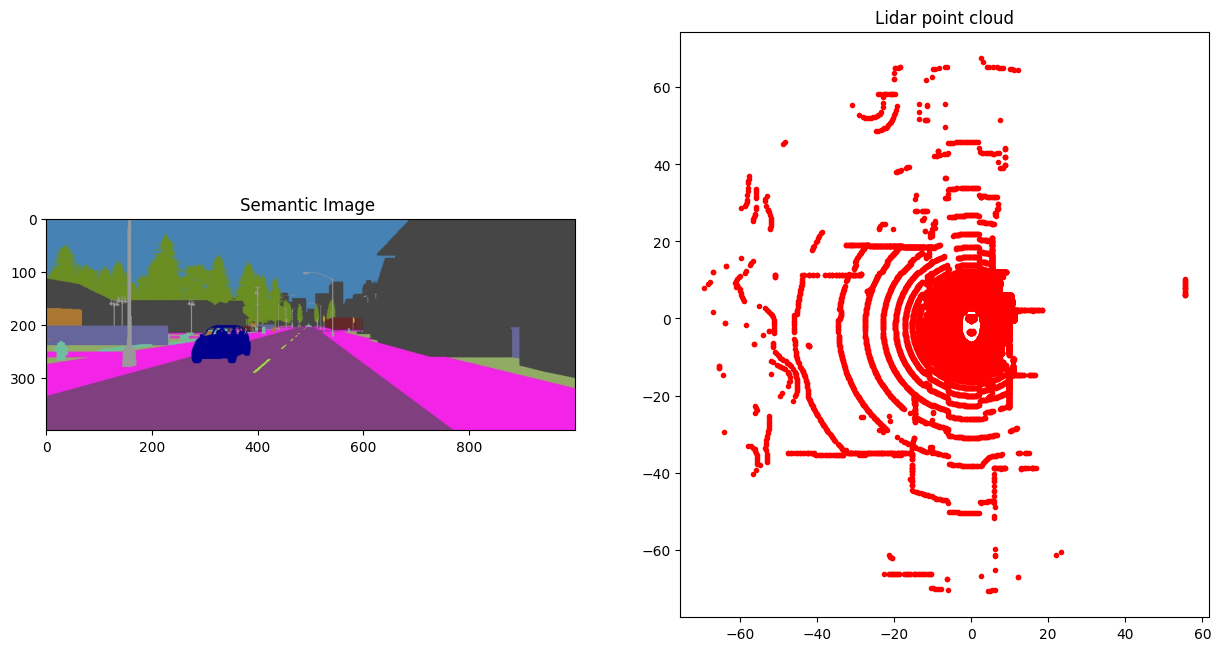

In [86]:
# Load data
img_seg,lidar_raw, intensity = load_data(folder_path,16)
img_raw_size = img_seg.shape

# Transforms the LiDAR points to camera coordinate space
lidar_raw = transform_coordinate(lidar_raw,16)

### Visualization

# Créer une figure et des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# Afficher l'image avec imshow dans le premier sous-graphique
axs[0].imshow(img_seg)
axs[ 0].set_title("Semantic Image ")

# Afficher le nuage de points Lidar dans le deuxième sous-graphique
axs[1].scatter(lidar_raw[:, 1], lidar_raw[:, 0], c='red', marker='.')
axs[1].scatter(0, 0, c='r', marker='x')
axs[1].axis('scaled')
axs[ 1].set_title("Lidar point cloud")

# Afficher la figure
plt.show()


This code segment performs several operations related to LiDAR point cloud projection onto the camera image plane and visualization:

  1. **Projection of LiDAR points onto the camera image plane**: The function project_lidar2cam takes LiDAR points in camera coordinates, camera intrinsic matrix, and the size of the camera image as input. It first filters out points that are behind the camera. Then, it projects the remaining points onto the camera image plane using the camera intrinsic matrix. It further filters out points that lie outside the image frame.

  2. **Projection of LiDAR points with pixel values**: The function project_lidar2cam_with_pixel_values extends the previous function by also retrieving the pixel values corresponding to the projected LiDAR points from the input semantic image. It returns the projected 2D points, 3D points, pixel values, and a combined array containing the positions of LiDAR points along with their corresponding pixel values.

  3. **Visualization**: After projecting the LiDAR points onto the camera image plane using both functions, the code visualizes the results. It creates scatter plots on the camera image showing the projected LiDAR points. The color intensity of the points is scaled based on the logarithm of the Z-coordinate of the LiDAR points to provide depth perception. The same process is repeated for another timestamp's data, and the results are visualized separately.

  4. **Filtering and Plotting**: Lastly, the code filters LiDAR points based on their Y-coordinates, plots the filtered LiDAR points in 2D, and visualizes the result.

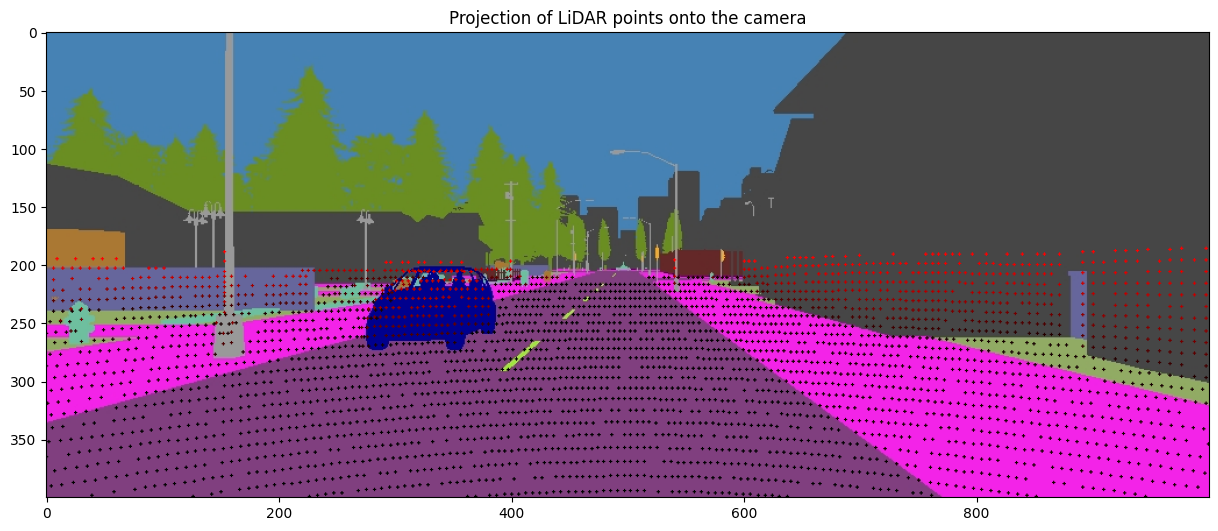

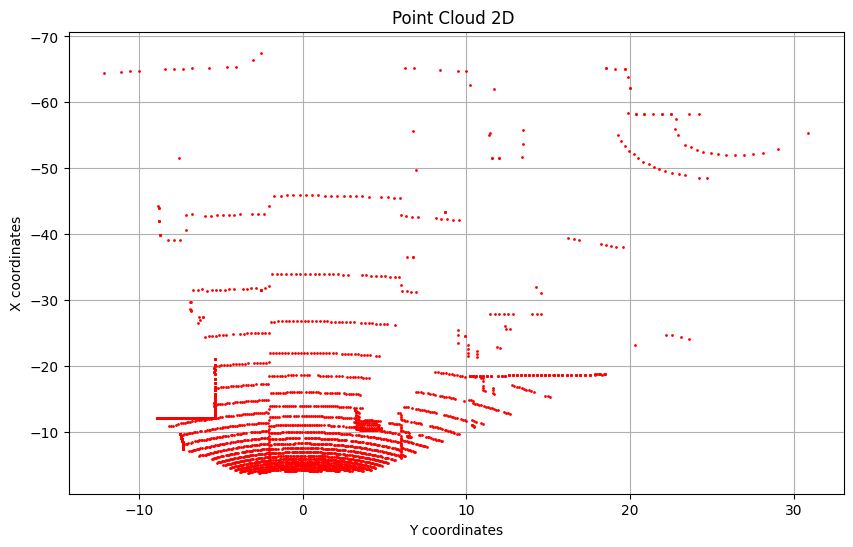

In [87]:
def project_lidar2cam(lidar_in_cam,camera_intrinsic,img_raw_size):

  ### Filter out data behind the cam
  lidar_in_cam = np.concatenate((lidar_in_cam,np.ones((lidar_in_cam.shape[0],1))),axis=1)
  lidar_in_cam = lidar_in_cam[lidar_in_cam[:,0]>0]

  ### Project points to the image
  point_in_camera_coords=np.array([
                lidar_in_cam[:,1],
                lidar_in_cam[:,2] * -1 ,
                lidar_in_cam[:,0]])
  points_2d = np.matmul(camera_intrinsic,point_in_camera_coords)

  # Normalize the x, y values by the 3rd value.
  points_2d = np.array([
                points_2d[0, :] / points_2d[2, :],
                points_2d[1, :] / points_2d[2, :],
                points_2d[2, :]])
  points_2d = points_2d.T
  points_2d = points_2d.astype(int)

  ### Filter out points that are outside image frame
  maskH = np.logical_and(points_2d[:,0]>=0,points_2d[:,0]<img_raw_size[1])
  maskV = np.logical_and(points_2d[:,1]>=0,points_2d[:,1]<img_raw_size[0])
  mask = np.logical_and(maskH,maskV)

  return points_2d,lidar_in_cam[:,:3],mask



def project_lidar2cam_with_pixel_values(lidar_in_cam, camera_intrinsic, img_raw_size, img):
    # Filter out data behind the camera
    lidar_in_cam = np.concatenate((lidar_in_cam, np.ones((lidar_in_cam.shape[0], 1))), axis=1)
    lidar_in_cam = lidar_in_cam[lidar_in_cam[:, 0] > 0]

    # Project points to the image
    point_in_camera_coords = np.array([
        lidar_in_cam[:, 1],
        lidar_in_cam[:, 2] * -1,
        lidar_in_cam[:, 0]])
    points_2d = np.matmul(camera_intrinsic, point_in_camera_coords)

    # Normalize the x, y values by the 3rd value
    points_2d = np.array([
        points_2d[0, :] / points_2d[2, :],
        points_2d[1, :] / points_2d[2, :],
        points_2d[2, :]])
    points_2d = points_2d.T
    points_2d = points_2d.astype(int)

    # Filter out points that are outside image frame
    maskH = np.logical_and(points_2d[:, 0] >= 0, points_2d[:, 0] < img_raw_size[1])
    maskV = np.logical_and(points_2d[:, 1] >= 0, points_2d[:, 1] < img_raw_size[0])
    mask = np.logical_and(maskH, maskV)

    # Get pixel values corresponding to Lidar points
    lidar_pixel_values = img[points_2d[mask, 1], points_2d[mask, 0]]

    # Create another array containing position of Lidar points and their corresponding pixel values
    lidar_position_and_pixel_values = np.column_stack((lidar_in_cam[mask, :3], lidar_pixel_values))

    return points_2d[mask], lidar_in_cam[mask, :3], lidar_pixel_values, lidar_position_and_pixel_values



lidar_2d,lidar_in_cam ,mask= project_lidar2cam(lidar_raw,camera_intrinsic,img_raw_size)
lidar_2d, lidar_in_cam, lidar_pixel_values, lidar_position_and_pixel_values = project_lidar2cam_with_pixel_values(lidar_in_cam, camera_intrinsic, img_raw_size, img_seg)



# Extract the screen coords (uv) as integers.
u_coord = lidar_2d[:, 0].astype(int)
v_coord = lidar_2d[:, 1].astype(int)


### Visualization
img = img_seg.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)
fig, ax = plt.subplots(figsize=(15, 7))
ax.imshow(img)
ax.set_title("Projection of LiDAR points onto the camera")
plt.show()

# Filter the 2D LiDAR points with x coordinates between 0.5 and -0.5.
lidar_2d_filtered = lidar_in_cam[(lidar_in_cam[:, 1] >= -30) & (lidar_in_cam[:, 1] <= 30)]

# Create a new figure and plot the filtered 2D LiDAR point cloud.
plt.figure(figsize=(10, 6))
plt.plot(-lidar_in_cam[:, 1], -lidar_in_cam[:, 0], 'ro', markersize=1)
plt.xlabel('Y coordinates')
plt.ylabel('X coordinates')
plt.title('Point Cloud 2D ')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()





This segment of code defines a function called **project_lidar2cam_segmented** that projects LiDAR points onto a camera image, considering the segmentation information provided by the image. It filters out points behind the camera, projects them onto the image plane, and associates each point with its corresponding pixel value based on the segmentation information. The function then returns the 2D coordinates of the projected points, the 3D coordinates of the LiDAR points, the segmented pixel values, and a combined array containing the position of LiDAR points and their corresponding segmented values.

After defining the function, the code segment utilizes it to project LiDAR points onto the camera image while considering segmentation information. It then creates a CSV file containing the segmented pixel values. Additionally, it assigns colors to segmented pixel values based on a predefined color mapping and visualizes the segmented point cloud in a scatter plot, with each point colored according to its segmentation label. Finally, it creates a 3D point cloud with labels based on the segmented pixel values for further analysis and visualization.

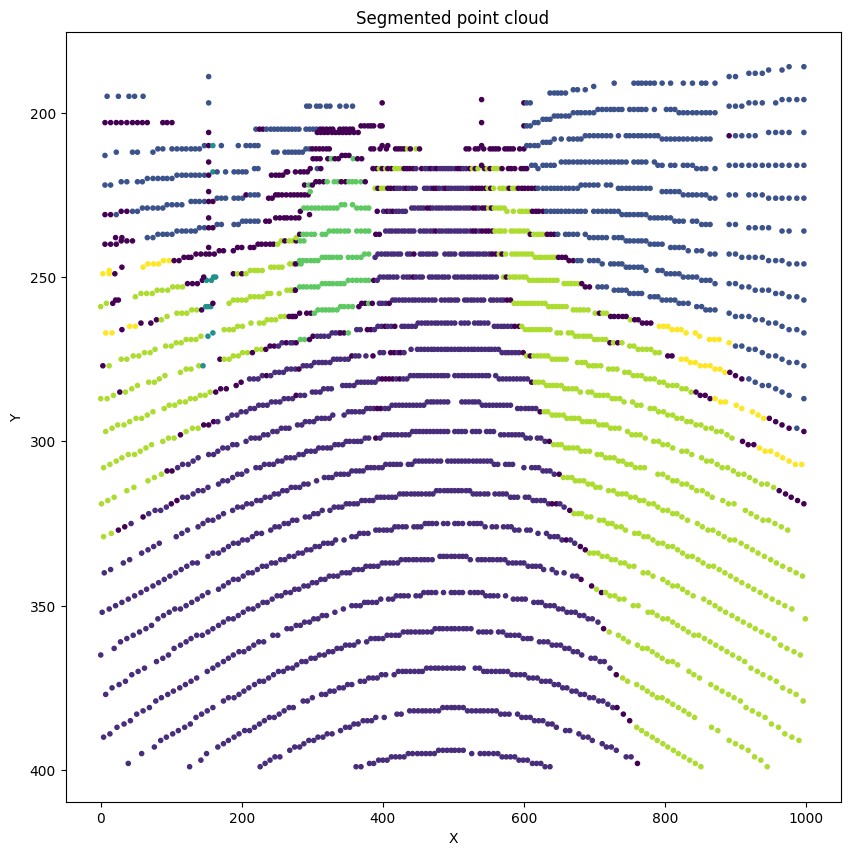

In [88]:
def project_lidar2cam_segmented(lidar_in_cam, camera_intrinsic, img_seg):
    # Filter out data behind the camera
    lidar_in_cam = np.concatenate((lidar_in_cam, np.ones((lidar_in_cam.shape[0], 1))), axis=1)
    lidar_in_cam = lidar_in_cam[lidar_in_cam[:, 0] > 0]

    # Project points to the image
    point_in_camera_coords = np.array([
        lidar_in_cam[:, 1],
        lidar_in_cam[:, 2] * -1,
        lidar_in_cam[:, 0]])
    points_2d = np.matmul(camera_intrinsic, point_in_camera_coords)

    # Normalize the x, y values by the 3rd value
    points_2d = np.array([
        points_2d[0, :] / points_2d[2, :],
        points_2d[1, :] / points_2d[2, :],
        points_2d[2, :]])
    points_2d = points_2d.T
    points_2d = points_2d.astype(int)

    # Filter out points that are outside image frame
    maskH = np.logical_and(points_2d[:, 0] >= 0, points_2d[:, 0] < img_seg.shape[1])
    maskV = np.logical_and(points_2d[:, 1] >= 0, points_2d[:, 1] < img_seg.shape[0])
    mask = np.logical_and(maskH, maskV)

    # Get pixel values corresponding to Lidar points
    lidar_segmented_values = img_seg[points_2d[mask, 1], points_2d[mask, 0]]

    # Create another array containing position of Lidar points and their corresponding pixel values
    lidar_position_and_segmented_values = np.column_stack((lidar_in_cam[mask, :3], lidar_segmented_values))

    return points_2d[mask], lidar_in_cam[mask, :3], lidar_segmented_values, lidar_position_and_segmented_values




lidar_2d, lidar_in_cam, lidar_segmented_values, lidar_position_and_segmented_values = project_lidar2cam_segmented(lidar_in_cam, camera_intrinsic, img_seg)
fichier_csv = '/content/drive/MyDrive/Data/ogm.csv'
with open(fichier_csv, 'w', newline='') as fichier:
    writer = csv.writer(fichier)
    writer.writerows(lidar_segmented_values)

# Creating a list of colors corresponding to segmented pixel values
reduced_label_colors = {
    (255, 255, 255): 0,       # None
    (128, 63, 127):  1,       # Road RoadLines
    (102,102,156) :  2,       # Building,Wall, static ,Fences
    (170,120,51):    2,       # Building,Wall, static ,Fences
    (70, 70, 70):    2,       # Building,Wall, static ,Fences
    (70, 70, 72):    2,       # Building,Wall, static ,Fences
    (250, 170, 30):  3,       # Other ,GuardRail ,RailTrack ,15Bridge
    (153, 153, 153): 4,       # Pole ;TrafficLight; Static
    (106, 142, 34):  5,       # Vegetation
    (0, 0, 142):     6,       # Vehicle Dynamic pedestrians
    (243, 35, 232):  7,       # Sidewalk Ground Terrain
    (145, 171, 100): 8,       # green ground
}
fichier_csv = '/content/drive/MyDrive/Data/ogm.csv'
with open(fichier_csv, 'w', newline='') as fichier:
    writer = csv.writer(fichier)
    writer.writerows(lidar_segmented_values)
# Creating a list of colors corresponding to segmented pixel values for each Lidar point
lidar_segmented_colors = []
default_color = 0
for value in lidar_segmented_values:
    color = reduced_label_colors.get(tuple(value), default_color)
    lidar_segmented_colors.append(color)

# Displaying the segmented point cloud
plt.figure(figsize=(10, 10))
plt.scatter(lidar_2d[:, 0], lidar_2d[:, 1], c=lidar_segmented_colors, marker='.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Segmented point cloud')
plt.gca().invert_yaxis()
plt.show()

# Create a three-dimensional point cloud (x, y, label)
lidar_3d_with_label = np.column_stack((lidar_2d[:, 0], lidar_2d[:, 1], lidar_segmented_values))
lidar_segmented_labels = [reduced_label_colors.get(tuple(value), 0) for value in lidar_segmented_values]

# Create a 3D point cloud with corresponding x, y coordinates, and labels.
lidar_3d_with_label = np.column_stack((lidar_in_cam[:, :2], lidar_segmented_labels))







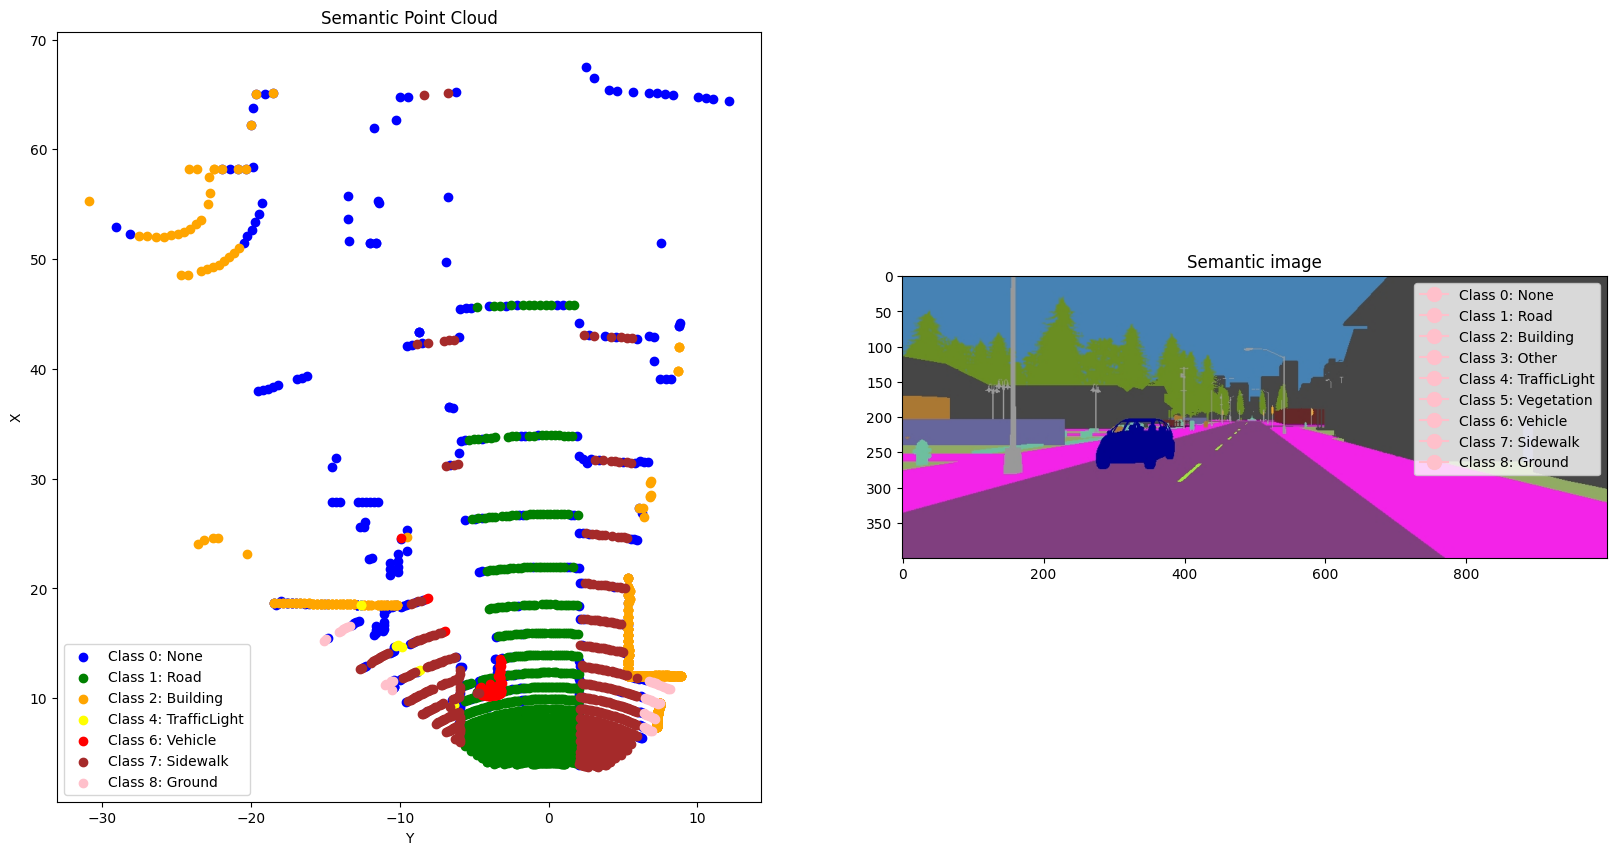

In [95]:
# Define the mapping dictionary between labels and class names.
label_names = {
    0: 'None',
    1: 'Road',
    2: 'Building',
    3: 'Other',
    4: 'TrafficLight',
    5: 'Vegetation',
    6: 'Vehicle',
    7: 'Sidewalk',
    8: 'Ground'
}

# Define the colors for each class.
class_colors = {
    0: 'blue',    # None
    1: 'green',   # Road
    2: 'orange',  # Building
    3: 'purple',  # Other
    4: 'yellow',  # Pole, TrafficLight
    5: 'cyan',    # Vegetation
    6: 'red',     # Vehicle
    7: 'brown',   # Sidewalk
    8: 'pink'     # Ground
}


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Visualize the point cloud based on their labels
for label in np.unique(lidar_segmented_labels):
    # Get the class name from the label_names dictionary
    class_name = label_names.get(int(label), 'Unknown')
    # Get the color for the class from the class_colors dictionary
    color = class_colors.get(int(label), 'gray')
    axs[0].scatter(lidar_in_cam[lidar_segmented_labels == label, 1], lidar_in_cam[lidar_segmented_labels == label, 0],
                   label=f'Class {label}: {class_name}', c=color)

# Add a legend to the first subplot
axs[0].legend()
axs[0].set_xlabel('Y')
axs[0].set_ylabel('X')
axs[0].set_title('Semantic Point Cloud')

# Display the semantic image with different colored classes
axs[1].imshow(img_seg)
axs[1].set_title('Semantic image')

# Display the different classes with colors in the legend of the second subplot
legend_patches = [plt.Line2D([0], [0], marker='o', color=color, label=f'Class {label}: {class_name}', markerfacecolor=color, markersize=10)
                  for label, class_name in label_names.items()]
axs[1].legend(handles=legend_patches)

# Show the figure
plt.show()